### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import SimpleRNN, RNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings('ignore')


Bad key "text.kerning_factor" on line 4 in
C:\Users\VISHAL SINGH\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [2]:
random.seed(1)

## Loading the dataset

In [3]:
df=pd.read_csv("WSJ_treebank_corpus.csv")
df.head()

,tokenized_sentences,tags
0,"['Pierre', 'Vinken', ',', '61', 'years', 'old'...","['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'M..."
1,"['Mr.', 'Vinken', 'is', 'chairman', 'of', 'Els...","['NNP', 'NNP', 'VBZ', 'NN', 'IN', 'NNP', 'NNP'..."
2,"['Rudolph', 'Agnew', ',', '55', 'years', 'old'...","['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', 'CC', '..."
3,"['A', 'form', 'of', 'asbestos', 'once', 'used'...","['DT', 'NN', 'IN', 'NN', 'RB', 'VBN', '-NONE-'..."
4,"['The', 'asbestos', 'fiber', ',', 'crocidolite...","['DT', 'NN', 'NN', ',', 'NN', ',', 'VBZ', 'RB'..."


### Preprocessing the data set


In [4]:
#Converting strings to list for each sentence in the data set
tokenized_sentences=df['tokenized_sentences']
X=np.array([ eval(x) for x in tokenized_sentences],dtype=object)
print("Number of words 1st sentence : "+str(len(X[0])))

Number of words 1st sentence : 18


In [5]:
tags=df['tags']
Y=np.array([ eval(x) for x in tags],dtype=object)
print("Number of tags in 1st sentence : "+str(len(Y[0])))


Number of tags in 1st sentence : 18


##### The number of tags for a particular sentence = number of words for that sentence

In [6]:
#comparing the length of every sentence and its corresponding set of tags
all([len(X[i])==len(Y[i]) for i in range(len(X))])

True

#### Vectorizing the inputs and the tags

In [7]:
#initializing the tokenizer
word_tokenizer = Tokenizer()   
word_tokenizer.fit_on_texts(X) 
#tokenizing input based on index of every word in vocab set
X_encoded = word_tokenizer.texts_to_sequences(X) 
X_encoded[0]

[5601,
 3746,
 1,
 2024,
 86,
 331,
 1,
 46,
 2405,
 2,
 131,
 27,
 6,
 2025,
 332,
 459,
 2026,
 3]

### Tokenizing the tags

In [8]:
tags_tokenizer = Tokenizer()
tags_tokenizer.fit_on_texts(Y)
Y_encoded = tags_tokenizer.texts_to_sequences(Y) # tokenizing each tag based on index in tag vocab.
Y_encoded[0]

[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9]

### Total Number of tags present in dataset

In [9]:
NUM_TAGS=len(tags_tokenizer.word_counts)
NUM_TAGS

46

In [10]:
#Total Number of words present in dataset
len(word_tokenizer.word_counts)

11387

In [11]:
#Checking if length of each encoded vector and it encoded tag vector are same or not
all_of_length = all([len(X_encoded[i])==len(Y[i]) for i in range(len(X_encoded))])
all_of_length

True

### Checking the length of different sequences in the dataset

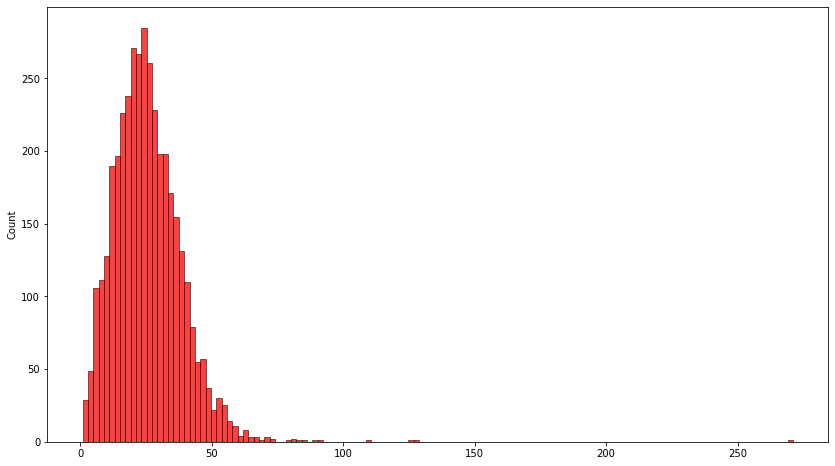

In [12]:
fig = plt.figure(figsize = (14, 8)) 
lengths_enc = [len(seq) for seq in X_encoded]
sns.histplot(lengths_enc,color = 'red')
plt.show()

Since the sentence vectors are of variable length we need to add padding and make all of same length 

In [13]:
max_len_enc=max(lengths_enc)
print("The maximum length vector among the all the encoded vector is {}".format(max_len_enc))

The maximum length vector among the all the encoded vector is 271


In [14]:
#Setting the MAX_VEC_LENGTH to be 100 such that vectors(sequences) greater than 100 in length
#will be truncated and for smaller vector zeroes will padded from the left
MAX_VEC_LENGTH = 100

X_padded = pad_sequences(X_encoded, maxlen=MAX_VEC_LENGTH, padding="pre", truncating="post")
X_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 5601, 3746,    1, 2024,   86,  331,
          1,   46, 2405,    2,  131,   27,    6, 2025,  332,  459, 2026,
          3])

In [15]:
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_VEC_LENGTH, padding="pre", truncating="post")
Y_padded[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  3,  8,
       10,  6,  7,  8, 21, 13,  4,  1,  2,  4,  7,  1,  3, 10,  9])

### Re-Assigning to X and Y for ease of use

In [16]:
X, Y = X_padded, Y_padded

### Word Embedding

In [17]:
# loading word2vec with vocab_limit of 20,000 for faster loading 
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',limit=20000, binary=True)

In [18]:
EMBED_DIM  = 300  #Representing each word as a 300 dimensional vector in word2vec
VOCAB_SIZE = len(word_tokenizer.word_index) + 1

# Empty embedding matrix
embedding_weights = np.zeros((VOCAB_SIZE, EMBED_DIM))

# Word to index dictionary mapping
word2id = word_tokenizer.word_index

# copying vectors from word2vec model to the words present in corpus
for word, index in word2id.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [19]:
print("Shape Embeddings is : {}".format(embedding_weights.shape))

Shape Embeddings is : (11388, 300)


### One hot Encoding for the POS tags

In [20]:
Y = to_categorical(Y)
print(Y.shape)

(3914, 100, 47)


### RNN with word (embedding weights)

In [21]:
def evaluate_model(X_train,Y_train,X_test,Y_test):
    Validation_Size=0.1 #Validation Split Size
    #Train - Validation Set Split
    X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=Validation_Size, random_state=1)
    # total number of tags
    NUM_CLASSES = Y.shape[2]
    rnn_model = Sequential()

    # Embedding layer - using the word2vec weights having dimension Vocab_size x Embed_dim
    rnn_model.add(Embedding(input_dim     =  VOCAB_SIZE,         
                            output_dim    =  EMBED_DIM,          
                            input_length  =  MAX_VEC_LENGTH,         
                            weights       = [embedding_weights],      
                            trainable     =  True                     # True - update the embeddings while training
    ))

    # Adding the RNN Layer containg 128 cells
    rnn_model.add(SimpleRNN(128, 
                  return_sequences=True  # True to return whole sequence output 
    ))
    rnn_model.add(Dropout(0.2)) # Adding dropout to avoid overfitting

    # Adding TimeDistributed layer - Softmax output based on number of classes or tags
    rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

    #Compiling model
    rnn_model.compile(loss      =  'categorical_crossentropy',
                      optimizer =  'adam',
                      metrics   =  ['acc'])
    
    print("Training - Validation(development) - Test set details :")
    
    # printing the number of samples in each set
    print("Training Set")
    print('Input Shape is : {}'.format(X_train.shape))
    print('Output Shape is : {}'.format(Y_train.shape))
    print("*"*70)
    
    print("Validation(Development) Set")
    print('Input Shape is : {}'.format(X_validation.shape))
    print('Output Shape is : {}'.format(Y_validation.shape))
    print("*"*70)
    
    print("Testing Set")
    print('Input Shape is : {}'.format(X_test.shape))
    print('Output Shape is : {}'.format(Y_test.shape))
    
    # model summary
    rnn_model.summary()
    #Hyper-parameters for the model
    epochs=15
    batch_size=64
    

    #Fitting Model
    rnn_training = rnn_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_validation, Y_validation))
    #Model Evaluation
    loss, accuracy = rnn_model.evaluate(X_train, Y_train, verbose = 1)
    print("Loss: {0},\nTraining Accuracy: {1}".format(loss, accuracy))
    print(" "*60)
    loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
    print("Loss: {0},\nTesting Accuracy: {1}".format(loss, accuracy))
    
    #Returning predicted set, test set and accuracy for further evaluation
    Y_pred=rnn_model.predict(X_test)
    return Y_pred,Y_test,accuracy

### 3 Fold Cross Validation of 70:10:20 split of data

In [22]:
from sklearn.model_selection import ShuffleSplit
#Shuffling and splitting into 3 different sets for cross validation
cv = ShuffleSplit(n_splits=3, test_size=.20, random_state=0)
cv_scores=[0]*3
itr=0
#Initializing
best_pred_set=None
best_test_set=None
best_accuracy=0 
#For each split creating and evaluating model
for train_idx,test_idx in cv.split(X):
    itr+=1
    print("*"*90)
    print("                        Cross Validation of {} iteration is : ".format(itr))
    print("*"*90)
    Pred_Set,Test_Set,cv_scores[itr-1]=evaluate_model(X[train_idx],Y[train_idx],X[test_idx],Y[test_idx])
    if cv_scores[itr-1]>best_accuracy:
        best_accuracy=cv_scores[itr-1]
        best_test_set=Test_Set
        best_pred_set=Pred_Set

******************************************************************************************
                        Cross Validation of 1 iteration is : 
******************************************************************************************
Training - Validation(development) - Test set details :
Training Set
Input Shape is : (2817, 100)
Output Shape is : (2817, 100, 47)
**********************************************************************
Validation(Development) Set
Input Shape is : (314, 100)
Output Shape is : (314, 100, 47)
**********************************************************************
Testing Set
Input Shape is : (783, 100)
Output Shape is : (783, 100, 47)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          3416400   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 

45/45 [==============================] - 8s 150ms/step - loss: 2.1378 - acc: 0.7053 - val_loss: 0.7645 - val_acc: 0.8264
Epoch 2/15
45/45 [==============================] - 7s 165ms/step - loss: 0.6794 - acc: 0.8466 - val_loss: 0.4470 - val_acc: 0.9115
Epoch 3/15
45/45 [==============================] - 7s 162ms/step - loss: 0.3828 - acc: 0.9235 - val_loss: 0.2429 - val_acc: 0.9556
Epoch 4/15
45/45 [==============================] - 7s 153ms/step - loss: 0.2022 - acc: 0.9639 - val_loss: 0.1530 - val_acc: 0.9693
Epoch 5/15
45/45 [==============================] - 7s 162ms/step - loss: 0.1228 - acc: 0.9774 - val_loss: 0.1126 - val_acc: 0.9750
Epoch 6/15
45/45 [==============================] - 7s 156ms/step - loss: 0.0816 - acc: 0.9852 - val_loss: 0.0921 - val_acc: 0.9777
Epoch 7/15
45/45 [==============================] - 8s 167ms/step - loss: 0.0580 - acc: 0.9886 - val_loss: 0.0805 - val_acc: 0.9793
Epoch 8/15
45/45 [==============================] - 7s 153ms/step - loss: 0.0445 - acc:

### Analysis of the best model among the 3 folds

In [23]:
print("Overall Testing Accuracy is : {}".format(sum(cv_scores)/len(cv_scores)))

Overall Testing Accuracy is : 0.9819242159525553


In [24]:
print("Best Testing Accuracy among all the folds is : {}".format(best_accuracy))

Best Testing Accuracy among all the folds is : 0.9825031757354736


In [25]:
print("Accuracies for 3 folds are :")
print(*cv_scores)

Accuracies for 3 folds are :
0.9812005162239075 0.9820689558982849 0.9825031757354736


In [26]:
print("Values of the best prediction set are :")
best_pred_set[0]

Values of the best prediction set are :


array([[9.91846919e-01, 1.74480563e-04, 1.02738457e-04, ...,
        1.10637746e-04, 2.47459568e-04, 2.30685415e-04],
       [9.99713361e-01, 7.71289433e-06, 6.38070333e-06, ...,
        2.92807385e-06, 9.04311491e-06, 8.31369289e-06],
       [9.99865174e-01, 2.84575185e-06, 2.46485365e-06, ...,
        9.43748773e-07, 3.52823236e-06, 3.73541570e-06],
       ...,
       [3.57720093e-03, 6.39729500e-01, 4.68909042e-03, ...,
        7.03340105e-04, 1.74069707e-03, 1.57341466e-03],
       [1.71360356e-04, 8.08609184e-04, 4.32083561e-06, ...,
        9.12347787e-06, 3.79405128e-06, 3.40950828e-05],
       [3.48258007e-04, 9.57011466e-08, 7.22553086e-05, ...,
        2.97503393e-05, 1.83110769e-05, 1.67617036e-05]], dtype=float32)

In [27]:
print("Values of the best testing set are :")
best_test_set[0]

Values of the best testing set are :


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Decoding the predicted tags in the best_pred_set

In [28]:
#Defining an empty matrix of zeros of shape of best_pred_set
out = np.zeros(best_pred_set.shape)
#Finding the tag index for each sequence which has the highest probablity value 
idx = best_pred_set.argmax(axis=-1)
#Setting that value to 1 and rest to 0
out[np.arange(best_pred_set.shape[0])[:,None],np.arange(best_pred_set.shape[1]),idx] = 1

In [29]:
#Finding the index havnig the max value among the 46 tag values for a certain sequence
best_pred=np.argmax(out, axis=2)
best_test=np.argmax(best_test_set,axis=2)
#Actual Tags(Encoded) for the 2nd sequence in Test Set
best_test[2]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  2, 10,  2,  4, 39,  7,  6,  2,  1,  8,  7,  1,  1,  2,  4,
        3,  3, 11, 15,  4,  7,  1,  2, 24, 10, 10,  5,  7,  1,  9],
      dtype=int64)

In [30]:
#Predicted Tags(Encoded) for the 2nd sequence in Test Set
best_pred[2]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  2, 10,  2,  4, 33, 19,  6,  2,  1,  8,  7,  1,  1,  2,  4,
        1,  1, 11, 15,  4,  7,  7,  2, 24, 10, 10,  5,  7,  1,  9],
      dtype=int64)

### Class-wise accuracy for the different tags

In [31]:
true_positive=[0]*(NUM_TAGS+1)
actual_count=[0]*(NUM_TAGS+1)
for i in range(best_test.shape[0]):
    for j in range(best_test.shape[1]):
        if best_test[i][j]==0: #Ignore if its 0 as it is present due to padding
            continue
        #if both are equal then increment count by 1 for true positive case
        if best_test[i][j]==best_pred[i][j]:
            true_positive[best_test[i][j]]+=1
        actual_count[best_test[i][j]]+=1

In [32]:
print("*"*90)
print("              class-wise accuracies of the different classes ")
print("*"*90)
class_accuracies=[]
for i in range(1,NUM_TAGS+1):
    if actual_count[i]!=0:
        class_accuracies.append((true_positive[i]/actual_count[i])*100)
        print("Accuracy of tag - class {} is {} %".format(i,(class_accuracies[i-1])))
    else:
        class_accuracies.append(0)
        print("Accuracy of tag - class {} is : NA ".format(i))

******************************************************************************************
              class-wise accuracies of the different classes 
******************************************************************************************
Accuracy of tag - class 1 is 92.61693080788558 %
Accuracy of tag - class 2 is 98.15762538382803 %
Accuracy of tag - class 3 is 86.83368869936035 %
Accuracy of tag - class 4 is 99.45021380574221 %
Accuracy of tag - class 5 is 97.72554965883245 %
Accuracy of tag - class 6 is 91.61624891961971 %
Accuracy of tag - class 7 is 81.35593220338984 %
Accuracy of tag - class 8 is 100.0 %
Accuracy of tag - class 9 is 100.0 %
Accuracy of tag - class 10 is 92.45014245014245 %
Accuracy of tag - class 11 is 90.06309148264984 %
Accuracy of tag - class 12 is 83.1918505942275 %
Accuracy of tag - class 13 is 93.86973180076629 %
Accuracy of tag - class 14 is 99.52718676122932 %
Accuracy of tag - class 15 is 100.0 %
Accuracy of tag - class 16 is 86.41975308641975 %
Ac

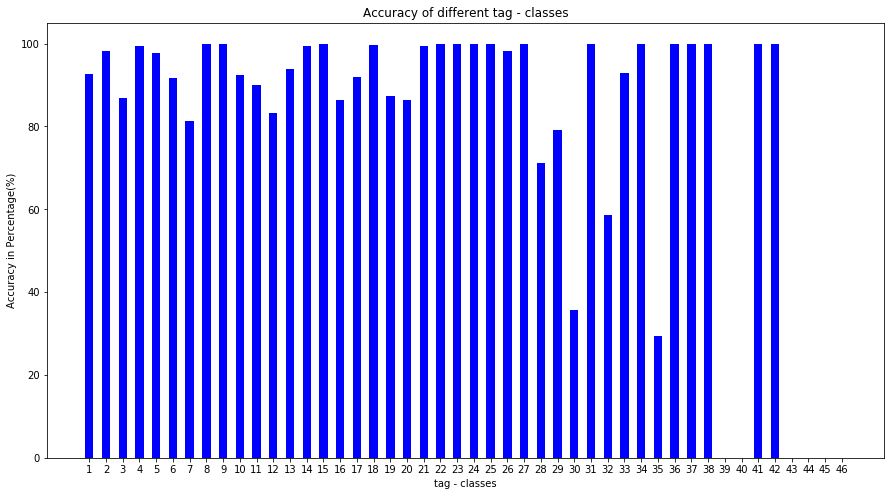

In [33]:
fig = plt.figure(figsize = (15, 8)) 
# creating the bar plot 
category_list=[str(i) for i in range(1,NUM_TAGS+1)]
plt.bar(category_list, class_accuracies, color ='blue',width = 0.5) 
  
plt.xlabel("tag - classes") 
plt.ylabel("Accuracy in Percentage(%)") 
plt.title("Accuracy of different tag - classes") 
plt.show() 